###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import torch
import os
import sys
from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets.Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [2]:
path_to_module = './'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

kmeans_is_enabled = False
ae_kmeans_is_enabled = False

### Visualization

In [3]:
visualization = Visualization()

### Load Dataset

In [4]:
dataset_name = "emnist_balanced_letters_A_J" # The available datasets are: emnist_balanced_digits, emnist_mnist, emnist_balanced_letters_A_J, emnist_balanced_letters_K_T, emnist_balanced_letters_U_Z, har, pendigits, waveform_v1, synthetic
module_name = "Datasets.Datasets"
batch_size = 256
n_clusters = 10
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, module_name, batch_size, n_clusters)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))
print(np.unique(labels))

Data_Shape is: 1
Batches Number is: 110
[10 11 12 13 14 15 16 17 18 19]


### Parameters

In [5]:
# Set latent dimension and negative slope
latent_dim = 5
negative_slope = 0

# Set pre-training epochs and learning rate
n_pret_epochs = 100
pret_lr = 1e-3

# Set lamdas, training epochs and learning rate
sil_lambda = 0.01
entr_lambda = 0.01
n_epochs = 100
lr = 5e-4

# Set kmeans_initialization, pretrain, is_mlp_ae
use_kmeans_initialization = True
use_pretrain = True
is_mlp_ae = False


### K-means experiment

In [6]:
if(kmeans_is_enabled):
    if(not is_mlp_ae):
        data_np = np.reshape(data_np, (len(data_np), 28 * 28))
    
    kmeans = KMeans(n_clusters, n_init=100).fit(data_np)
    evaluator = Evaluator()
    evaluator.evaluate_model(data_np, labels, kmeans.labels_)

### Create Autoencoder Model

In [7]:
if is_mlp_ae:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
autoencoder.set_path()
autoencoder = autoencoder.to(device)

### Pretrain Autoencoder

In [8]:
if(use_pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + '/Weigths/autoencoder_weights.pth'
    autoencoder.load_state_dict(torch.load(model_save_path))

Epoch: 0, Loss: 66.657739
Epoch: 1, Loss: 43.136513
Epoch: 2, Loss: 30.977005
Epoch: 3, Loss: 22.224655
Epoch: 4, Loss: 15.921245
Epoch: 5, Loss: 11.547287
Epoch: 6, Loss: 8.481184
Epoch: 7, Loss: 6.498824
Epoch: 8, Loss: 5.239242
Epoch: 9, Loss: 4.495798
Epoch: 10, Loss: 4.072914
Epoch: 11, Loss: 3.821449
Epoch: 12, Loss: 3.693970
Epoch: 13, Loss: 3.618438
Epoch: 14, Loss: 3.585812
Epoch: 15, Loss: 3.534263
Epoch: 16, Loss: 3.536818
Epoch: 17, Loss: 3.519050
Epoch: 18, Loss: 3.476521
Epoch: 19, Loss: 3.453536
Epoch: 20, Loss: 3.466260
Epoch: 21, Loss: 3.425197
Epoch: 22, Loss: 3.408236
Epoch: 23, Loss: 3.408660
Epoch: 24, Loss: 3.390504
Epoch: 25, Loss: 3.365378
Epoch: 26, Loss: 3.361097
Epoch: 27, Loss: 3.353541
Epoch: 28, Loss: 3.345135
Epoch: 29, Loss: 3.349274
Epoch: 30, Loss: 3.305069
Epoch: 31, Loss: 3.298619
Epoch: 32, Loss: 3.280098
Epoch: 33, Loss: 3.278305
Epoch: 34, Loss: 3.275234
Epoch: 35, Loss: 3.230004
Epoch: 36, Loss: 3.229767
Epoch: 37, Loss: 3.221517
Epoch: 38, Loss:

### Autoencoder + K-means experiment

In [9]:
if(ae_kmeans_is_enabled):
    data, latent_data, labels = autoencoder.get_latent_data()
    kmeans = KMeans(n_clusters=n_clusters, n_init=100).fit(latent_data)
    evaluator = Evaluator()
    evaluator.evaluate_model(data, labels, kmeans.labels_)

### Initialize the clustering layer using k-means

In [10]:
n_inits = 100
if use_kmeans_initialization: autoencoder.kmeans_initialization(n_inits)

ACC: 0.68 PUR: 0.71 NMI: 0.61 ARI: 0.51


### Train Autoencoder

In [11]:
#autoencoder.set_training_variables(n_epochs=100, lr=5e-4, sil_lambda=0.01, entr_lambda=0.01)
latent_data, labels, clustering = autoencoder.train_autoencoder()

Ep: 0 Rec L: 2.8979 Cl L: 1.1989 Entropy: 2.9611 SSil: -9.8947 SIL: 0.0000 ACC: 0.71 PUR: 0.74 NMI: 0.64 ARI: 0.55
Ep: 1 Rec L: 2.9802 Cl L: 1.1578 Entropy: 2.5485 SSil: -5.7805 SIL: 0.0000 ACC: 0.74 PUR: 0.77 NMI: 0.68 ARI: 0.60
Ep: 2 Rec L: 3.0676 Cl L: 1.0981 Entropy: 2.2443 SSil: 0.1914 SIL: 0.0000 ACC: 0.76 PUR: 0.79 NMI: 0.71 ARI: 0.64
Ep: 3 Rec L: 3.0942 Cl L: 1.0570 Entropy: 2.0907 SSil: 4.2961 SIL: 0.0000 ACC: 0.77 PUR: 0.80 NMI: 0.72 ARI: 0.65
Ep: 4 Rec L: 3.1167 Cl L: 1.0263 Entropy: 2.0020 SSil: 7.3710 SIL: 0.0000 ACC: 0.78 PUR: 0.80 NMI: 0.73 ARI: 0.67
Ep: 5 Rec L: 3.1178 Cl L: 1.0108 Entropy: 1.9537 SSil: 8.9182 SIL: 0.0000 ACC: 0.78 PUR: 0.81 NMI: 0.74 ARI: 0.67
Ep: 6 Rec L: 3.0914 Cl L: 0.9926 Entropy: 1.9085 SSil: 10.7392 SIL: 0.0000 ACC: 0.78 PUR: 0.81 NMI: 0.74 ARI: 0.68
Ep: 7 Rec L: 3.1372 Cl L: 0.9799 Entropy: 1.8798 SSil: 12.0098 SIL: 0.0000 ACC: 0.79 PUR: 0.81 NMI: 0.75 ARI: 0.68
Ep: 8 Rec L: 3.1043 Cl L: 0.9646 Entropy: 1.8464 SSil: 13.5371 SIL: 0.0000 ACC: 0.79

### Save Clustering Results

In [ ]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/waveform_v1/SSAE/100_Eps_ld_5_out_3_bs_256_lr_0.0005_sil_lambda_0.01_entr_lambda_0.01' already exists.


### Plot Clustering Results

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5003 samples in 0.003s...
[t-SNE] Computed neighbors for 5003 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5003
[t-SNE] Computed conditional probabilities for sample 2000 / 5003
[t-SNE] Computed conditional probabilities for sample 3000 / 5003
[t-SNE] Computed conditional probabilities for sample 4000 / 5003
[t-SNE] Computed conditional probabilities for sample 5000 / 5003
[t-SNE] Computed conditional probabilities for sample 5003 / 5003
[t-SNE] Mean sigma: 0.019870
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.424240
[t-SNE] KL divergence after 300 iterations: 2.232430
Directory './Results/waveform_v1/SSAE/100_Eps_ld_5_out_3_bs_256_lr_0.0005_sil_lambda_0.01_entr_lambda_0.01/Experiments/TSNE' already exists.


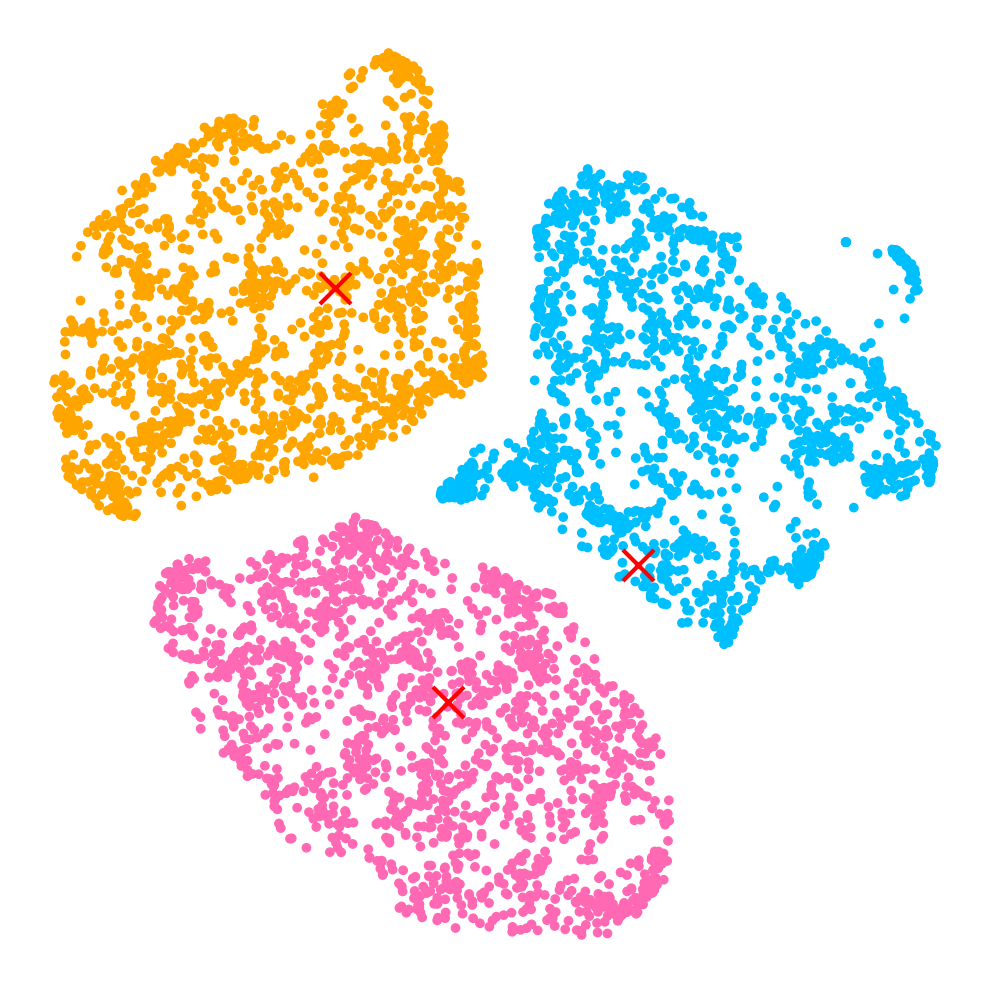

In [ ]:
cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()
data, latent_data, labels = autoencoder.get_latent_data()
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)